In [1]:
base_data_path = "data/mymethod/"

In [2]:
!ls data/mymethod

archive  testing.pt  training.pt  val.pt


In [47]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

In [4]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float16)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
training_dataset = torch.load("data/mymethod/training.pt")
testing_dataset = torch.load("data/mymethod/testing.pt")
val_dataset = torch.load("data/mymethod/val.pt")

/tmp/ipykernel_26520/2319508829.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("data/mymethod/training.pt")
/tmp/ipykernel_26520/231950882

In [6]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [7]:
# Convert dataset outcomes to float32
def convert_dataset_to_float32(dataset):
    dataset.y = dataset.y.to(torch.float32)
    return dataset

# Convert all datasets
training_dataset = convert_dataset_to_float32(training_dataset)
testing_dataset = convert_dataset_to_float32(testing_dataset)
val_dataset = convert_dataset_to_float32(val_dataset)


In [9]:
# Define a simple two-layer neural net with dropout and layer norm
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x


In [10]:
input_dim = int(testing_dataset.X[0].shape[0])
hidden_dim = int(testing_dataset.X[0].shape[0]/2)

In [51]:
model = SimpleNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

In [52]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

criterion = nn.MSELoss()

In [53]:
num_epochs = 20

In [54]:
# Prepare data loaders
batch_size = 512
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


In [55]:
train_losses = []
test_losses = []

for epoch_num in range(num_epochs):
    
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")
        

    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)  
    print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")
        
        

TEST LOSS: PRE Epoch-0, we have 129.8516


Training Epoch 0:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-0, we have 96.6622
TEST LOSS: PRE Epoch-1, we have 75.4620


Training Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-1, we have 76.5835
TEST LOSS: PRE Epoch-2, we have 69.9141


Training Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-2, we have 71.5013
TEST LOSS: PRE Epoch-3, we have 65.3251


Training Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-3, we have 66.6561
TEST LOSS: PRE Epoch-4, we have 60.6618


Training Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-4, we have 62.0381
TEST LOSS: PRE Epoch-5, we have 56.1731


Training Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-5, we have 57.8613
TEST LOSS: PRE Epoch-6, we have 52.2715


Training Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-6, we have 54.2370
TEST LOSS: PRE Epoch-7, we have 48.6465


Training Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-7, we have 50.3258
TEST LOSS: PRE Epoch-8, we have 44.9999


Training Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-8, we have 46.8138
TEST LOSS: PRE Epoch-9, we have 42.2829


Training Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-9, we have 44.3393
TEST LOSS: PRE Epoch-10, we have 39.9922


Training Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-10, we have 42.3403
TEST LOSS: PRE Epoch-11, we have 38.5285


Training Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-11, we have 40.8324
TEST LOSS: PRE Epoch-12, we have 37.2779


Training Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-12, we have 39.5219
TEST LOSS: PRE Epoch-13, we have 36.3729


Training Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-13, we have 38.5233
TEST LOSS: PRE Epoch-14, we have 35.1824


Training Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-14, we have 37.3833
TEST LOSS: PRE Epoch-15, we have 34.2704


Training Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-15, we have 36.3798
TEST LOSS: PRE Epoch-16, we have 33.3555


Training Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-16, we have 35.4306
TEST LOSS: PRE Epoch-17, we have 32.6266


Training Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-17, we have 34.5712
TEST LOSS: PRE Epoch-18, we have 31.7277


Training Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-18, we have 33.7883
TEST LOSS: PRE Epoch-19, we have 31.0267


Training Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-19, we have 33.0171


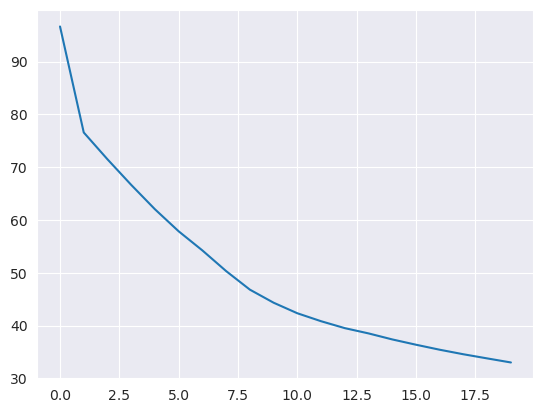

In [56]:
plt.plot(train_losses)

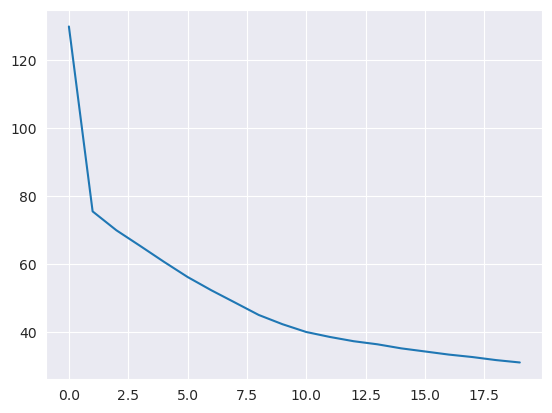

In [57]:
plt.plot(test_losses)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [59]:
val_loss = 0.0
model.eval()
with torch.no_grad():
    # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        # test_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = val_loss/len(testing_dataset)
    print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")

ON VAL SET, ACHIEVED 30.1647


In [ ]:
# Define the train function for 1 epoch
def train_one_epoch(model, dataloader, optimizer, device, epoch):


In [ ]:
# Define the evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloader, desc="Evaluating")):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Validation Loss = {avg_loss:.4f}")
    return avg_loss



In [ ]:
input_dim = training_dataset.X.shape[1]
hidden_dim = 512
output_dim = 1




In [ ]:
optimizer = get_optimizer(model, learning_rate=0.001)

In [ ]:
# Train and evaluate
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, device, epoch)
    eval_loss = evaluate(model, val_loader, device)
    print(f"Epoch {epoch}: Validation Loss = {eval_loss:.4f}")